https://www.tensorflow.org/tutorials/generative/adversarial_fgsm

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import tensorflow as tf

In [2]:
mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

In [3]:
pretrained_model = tf.keras.applications.MobileNetV2(
    include_top=True,
    weights='imagenet'
)

pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

14536120/14536120 [==============================] - 1s 0us/step


In [5]:
def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    image = image[None, ...]
    return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
    return decode_predictions(probs, top=1)[0][0]

In [6]:
image_path = tf.keras.utils.get_file(
    'YellowLabradorLooking_new.jpg',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'
)

image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)
image = preprocess(image)
image_probs = pretrained_model.predict(image)

1/1 [==============================] - 7s 7s/step


35363/35363 [==============================] - 0s 0us/step


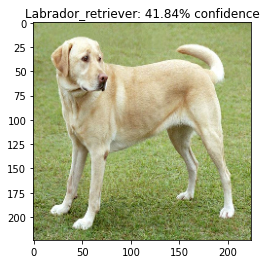

In [7]:
plt.figure()
plt.imshow(image[0] * 0.5 + 0.5) # To change [-1, 1] to [0, 1]

_, image_class, class_confidence = get_imagenet_label(image_probs)

plt.title(f'{image_class}: {class_confidence * 100:.2f}% confidence')
plt.show()

In [8]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
    with tf.GradientTape() as tape:
        tape.watch(input_image)

        prediction = pretrained_model(input_image)
        loss = loss_object(input_label, prediction)

    gradient = tape.gradient(loss, input_image)

    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    return signed_grad

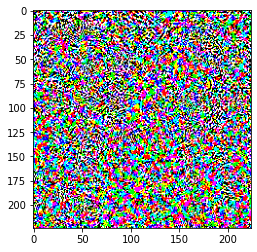

In [9]:
labrador_retriever_index = 208

label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)

plt.imshow(perturbations[0] * 0.5 + 0.5);

In [10]:
def display_images(image, description):
    _, label, confidence = get_imagenet_label(pretrained_model.predict(image))

    plt.figure()
    plt.imshow(image[0] * 0.5 + 0.5)
    plt.title(f'{description}\n{label}: {confidence * 100:.2f}% confidence')
    plt.show()

1/1 [==============================] - 0s 32ms/step


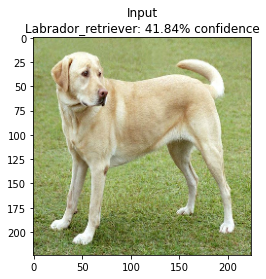

1/1 [==============================] - 0s 33ms/step


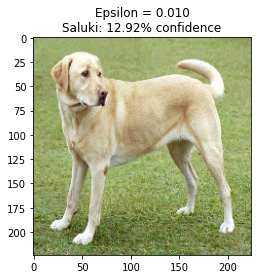

1/1 [==============================] - 0s 24ms/step


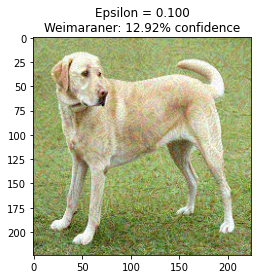

1/1 [==============================] - 0s 24ms/step


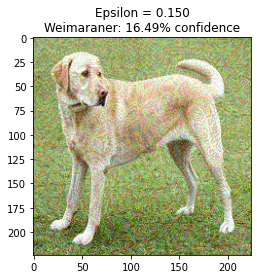

In [11]:
epsilons = [0, 0.01, 0.1, 0.15]

descriptions = [
    (f'Epsilon = {eps:.3f}' if eps else 'Input')
    for eps in epsilons
]

for i, eps in enumerate(epsilons):
    adv_x = image + eps * perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)

    display_images(adv_x, descriptions[i])